##### Introdução

Com a baseline previamente estabelecida, este trecho tem como objetivo utilizá-la como referência central para a realização de comparações e validações dos resultados obtidos ao longo do desenvolvimento. A partir dessa linha de base, será possível mensurar de forma objetiva o impacto de diferentes configurações e abordagens no desempenho do sistema, permitindo uma análise criteriosa e fundamentada no contexto da Neuro-Evolução.

**dados**
-   Os dados analisados são referentes às <a href="https://gml.noaa.gov/ccgg/trends/gl_data.html">Tendências do dióxido de carbono atmosférico</a>, cobrindo o período de 1979 à 2024.
-   As medições estão na escala de partes por milhão (ppm). Por exemplo uma concentração de 0,000400 corresponde a 400 ppm.
    -   **Mais especificamente:** a medição representa uma fração molar de CO₂ no ar seco, ou seja, o número de moléculas de dióxido de carbono dividido pelo número total de moléculas no ar (incluindo o próprio CO₂), após a remoção do vapor d’água.

**dataSet**
-   Obtido a partir do site <a href="https://gml.noaa.gov/">gml.noaa.gov</a>, que é um site oficial do governo dos Estados Unidos, cuja sigla GML e NOAA significam respectivamente, Global Monitoring Laboratory (Laboratório de Monitoramento Global) e National Oceanic and Atmospheric Administration (Administração Oceânica e Atmosférica Nacional)

## Pip Install e importação de bibliotecas

In [15]:
# pip install tensorflow pandas numpy

In [16]:
# Bibliotecas principais do TensorFlow e Keras para Deep Learning
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop

# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt

# Controle de aleatoriedade e ambiente
import random
import os

# Pré-processamento e divisão de dados
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

# Métricas de avaliação
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# Bibliotecas auxiliares
import aux_functions as aux
import importlib
importlib.reload(aux)

<module 'aux_functions' from '/home/elizeta/VsCode/Otimizacao-de-Gas-com-Neuro-Evolucao/Trends_Atmospheric_CO2/aux_functions.py'>

# Análise de Séries temporais com Deep Learning Com Cross-Validation

In [17]:
# Garantir reprodutibilidade total
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [18]:
full_data_set = aux.ler_csv('dataSet.csv')
series = aux.ler_csv('dataSet.csv', average_only=True)

series

data
1979-01-01    336.56
1979-02-01    337.29
1979-03-01    337.88
1979-04-01    338.32
1979-05-01    338.26
               ...  
2024-08-01    420.19
2024-09-01    420.50
2024-10-01    422.32
2024-11-01    424.07
2024-12-01    425.19
Name: average, Length: 552, dtype: float64

In [19]:
dataset = series.values
dataset = dataset.astype(np.float32)

print(type(dataset))
dataset

<class 'numpy.ndarray'>


array([336.56, 337.29, 337.88, 338.32, 338.26, 337.38, 335.56, 334.36,
       335.02, 336.36, 337.36, 337.89, 338.57, 339.26, 339.59, 339.99,
       340.44, 339.99, 338.44, 337.21, 337.05, 337.82, 338.93, 339.64,
       340.18, 340.75, 341.38, 341.68, 341.43, 340.63, 339.23, 338.08,
       337.97, 339.07, 340.18, 340.75, 341.36, 341.95, 342.23, 342.52,
       342.36, 341.49, 339.75, 338.11, 338.16, 339.62, 340.95, 341.77,
       342.37, 342.74, 343.04, 343.51, 343.84, 343.5 , 342.14, 340.62,
       340.53, 341.75, 342.83, 343.49, 344.32, 344.82, 344.96, 345.19,
       345.33, 344.57, 343.2 , 342.21, 342.13, 342.99, 344.16, 345.  ,
       345.35, 345.8 , 346.64, 346.94, 346.78, 346.26, 344.92, 343.41,
       343.37, 344.64, 345.79, 346.55, 347.11, 347.34, 347.71, 348.22,
       348.32, 347.76, 346.29, 344.92, 344.86, 346.03, 347.3 , 347.76,
       348.02, 348.57, 349.29, 349.98, 350.26, 349.48, 347.86, 346.61,
       346.7 , 347.97, 349.25, 350.21, 350.91, 351.47, 351.85, 352.3 ,
      

In [20]:
window_size = 12
X, y = aux.criarJanelas(dataset, window_size)
X[:3], y[:3]

(array([[336.56, 337.29, 337.88, 338.32, 338.26, 337.38, 335.56, 334.36,
         335.02, 336.36, 337.36, 337.89],
        [337.29, 337.88, 338.32, 338.26, 337.38, 335.56, 334.36, 335.02,
         336.36, 337.36, 337.89, 338.57],
        [337.88, 338.32, 338.26, 337.38, 335.56, 334.36, 335.02, 336.36,
         337.36, 337.89, 338.57, 339.26]], dtype=float32),
 array([338.57, 339.26, 339.59], dtype=float32))

In [21]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size = 0.70, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size = 0.5, shuffle=False)

print(f"DataSet size:   {len(dataset):>8}\n"
      f"Train size:     {len(X_train):>8}\n"
      f"Validation size:{len(X_val):>8}\n"
      f"Test size:      {len(X_test):>8}\n"
      f"Window Size:    {window_size:>8}")
# Pela criação das janelas, o tamanho do dataset não é igual a soma dos tamanhos de treino, validação e teste

DataSet size:        552
Train size:          378
Validation size:      81
Test size:            81
Window Size:          12


In [22]:
scaler = MinMaxScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)
X_scaled_test = scaler.transform(X_test)


print(X_scaled_test.shape)

(81, 12)


In [23]:
def create_model(df_shape, neurons=12, loss='mse', dropout_rate=0):
    model = models.Sequential([
        Input(shape=(df_shape,)),

        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),

        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),

        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),

        Dense(8, activation='relu'),  
        Dropout(dropout_rate),

        Dense(1) # Talvez adicionar uma camada de ativação aqui
    ])

    model.compile(optimizer=Adam(), loss=loss, metrics=['mae'])
    return model

In [24]:
# def create_model(df_shape, neural_network_layers, neurons=12, optimizer='adam', loss='mse', dropout_rate=0):
#     model = models.Sequential(neural_network_layers)

#     optimizer_instance = Adam() if optimizer == 'adam' else RMSprop()
#     model.compile(optimizer=optimizer_instance, loss=loss, metrics=['mae'])
#     return model

In [25]:
# layers = [
#     [
#         Input(shape=(df_shape,)),

#         Dense(neurons, activation='relu'),
#         Dropout(dropout_rate),

#         Dense(neurons, activation='relu'),
#         Dropout(dropout_rate),

#         Dense(neurons, activation='relu'),
#         Dropout(dropout_rate),

#         Dense(8, activation='relu'),  
#         Dropout(dropout_rate),

#         Dense(1) # Talvez adicionar uma camada de ativação aqui
#     ],
#     [
        
#     ]
# ]

In [26]:
tscv = TimeSeriesSplit(n_splits=5)

In [27]:
mse_scores = []

neurons = 12
epochs = 10000
batch_size = 36

for train_index, val_index in tscv.split(X_scaled_train):
    X_train_fold, X_val_fold = X_scaled_train[train_index], X_scaled_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = create_model(X_train_fold.shape[1], neurons=neurons)

    model.fit(X_train_fold,
                y_train_fold,
                epochs=epochs,
                batch_size=batch_size,
                verbose=1)

    y_pred = model.predict(X_val_fold)
    mse = mean_squared_error(y_val_fold, y_pred)
    mse_scores.append(mse)


print("MSE médio nos folds:", np.mean(mse_scores))



Epoch 1/10000


E0000 00:00:1748262450.347478    7489 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748262450.350456    7489 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-05-26 09:27:30.446812: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parall

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 116666.7578 - mae: 341.5564 
Epoch 2/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 116652.0781 - mae: 341.5349
Epoch 3/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116636.7422 - mae: 341.5125
Epoch 4/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 116622.8047 - mae: 341.4921
Epoch 5/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116611.1094 - mae: 341.4750
Epoch 6/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116602.0938 - mae: 341.4618
Epoch 7/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116594.2031 - mae: 341.4503
Epoch 8/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116587.0938 - mae: 341.4399
Epoch 9/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116580.2031 - mae: 341.4298
Epoch 10/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 116573.2812 - mae: 341.4197
Epoch 11/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 116565.9922 - mae: 341.4090
Epoch 12/10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-05-26 09:34:05.286626: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 119469.6328 - mae: 345.6046  
Epoch 2/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 119442.8047 - mae: 345.5660 
Epoch 3/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119421.3047 - mae: 345.5350 
Epoch 4/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 119410.0938 - mae: 345.5189 
Epoch 5/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119402.7031 - mae: 345.5081 
Epoch 6/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 119395.7344 - mae: 345.4981 
Epoch 7/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 119389.6797 - mae: 345.4894 
Epoch 8/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119384.6016 - mae: 345.4821 
Epoch 9/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119380.1875 - mae: 345.4757 
Epoch 10/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 119375.6719 - mae: 345.4692 
Epoch 11/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 119370.7969 - mae: 345.4621 
Epoch 12/10000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-05-26 09:40:02.879653: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121952.7734 - mae: 349.1483  
Epoch 2/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121930.1719 - mae: 349.1161 
Epoch 3/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121919.2891 - mae: 349.1006 
Epoch 4/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121912.8594 - mae: 349.0914 
Epoch 5/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121906.6406 - mae: 349.0825 
Epoch 6/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121897.8906 - mae: 349.0700 
Epoch 7/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121883.6797 - mae: 349.0497 
Epoch 8/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121868.0859 - mae: 349.0275 
Epoch 9/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 121852.7031 - mae: 349.0055 
Epoch 10/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121834.9141 - mae: 348.9801 
Epoch 11/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121814.1875 - mae: 348.9505 
Epoch 12/10000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-05-26 09:45:54.304640: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 124888.5234 - mae: 353.2818  
Epoch 2/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 124841.7500 - mae: 353.2162 
Epoch 3/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124816.0078 - mae: 353.1800 
Epoch 4/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124793.8438 - mae: 353.1487 
Epoch 5/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124767.2656 - mae: 353.1111 
Epoch 6/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124735.2578 - mae: 353.0659 
Epoch 7/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124696.9688 - mae: 353.0119 
Epoch 8/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124650.6250 - mae: 352.9465 
Epoch 9/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124594.0781 - mae: 352.8668 
Epoch 10/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 124524.7109 - mae: 352.7689 
Epoch 11/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124439.2188 - mae: 352.6484 
Epoch 12/10000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-05-26 09:51:15.477189: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 128000.6797 - mae: 357.5668  
Epoch 2/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127967.5391 - mae: 357.5207 
Epoch 3/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127924.4375 - mae: 357.4606 
Epoch 4/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 127867.2656 - mae: 357.3812 
Epoch 5/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127784.5312 - mae: 357.2662 
Epoch 6/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127647.5312 - mae: 357.0763 
Epoch 7/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 127432.9453 - mae: 356.7791 
Epoch 8/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127124.3125 - mae: 356.3514 
Epoch 9/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 126701.2266 - mae: 355.7645 
Epoch 10/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126132.1172 - mae: 354.9732 
Epoch 11/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125364.1250 - mae: 353.9025 
Epoch 12/10000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 

2025-05-26 09:56:55.004709: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


  🔹 R² (Coeficiente de Determinação): ------------ 0.9789
  🔹 RMSE (Raiz Quadrada do Erro Quadrático Médio): 0.4988
  🔹 MAE (Erro Absoluto Médio): ------------------- 0.4665
  🔹 MAPE (Erro Percentual Absoluto): ------------- 1.0268%
  🔹 Acurácia: ------------------------------------ 98.9732%
  🔹 Neurons: -- 12
  🔹 Epochs: --- 10000
  🔹 Batch Size: 36


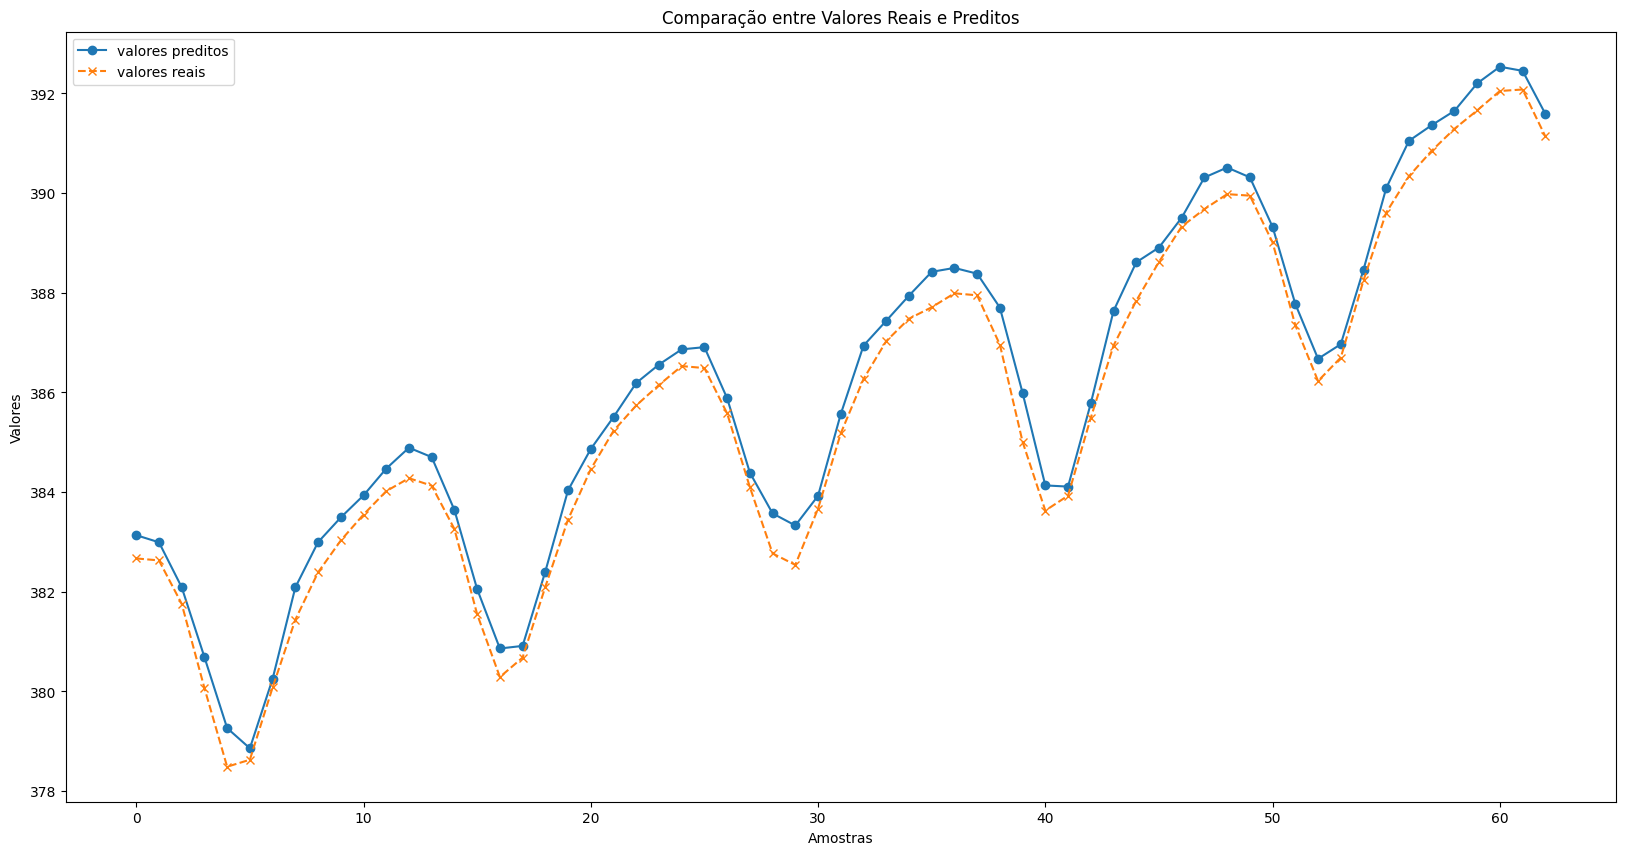

In [28]:
def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0  # Evitar divisão por zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Calcular métricas
# f1 = f1_score(y_val_fold, y_pred)
r2 = r2_score(y_val_fold, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
mae = mean_absolute_error(y_val_fold, y_pred)
mape = mean_absolute_percentage_error(y_val_fold, y_pred)
accuracy = 100 - mape

# print(f"  🔹 R² (Coeficiente de Determinação): {f1:.2f}") #Função criada para teste, entretanto não foi possivel aplicar aqui
print(f"  🔹 R² (Coeficiente de Determinação): ------------ {r2:.4f}")
print(f"  🔹 RMSE (Raiz Quadrada do Erro Quadrático Médio): {rmse:.4f}")
print(f"  🔹 MAE (Erro Absoluto Médio): ------------------- {mae:.4f}")
print(f"  🔹 MAPE (Erro Percentual Absoluto): ------------- {mape:.4f}%")
print(f"  🔹 Acurácia: ------------------------------------ {accuracy:.4f}%")

print(f'  🔹 Neurons: -- {neurons}')
print(f'  🔹 Epochs: --- {epochs}')
print(f'  🔹 Batch Size: {batch_size}')

aux.plotLine(
    y_pred,
    df_label="valores preditos",
    df_marker='o',
    compare=y_val_fold,
    compare_label="valores reais",
    compare_marker='x',
    xlabel="Amostras",
    ylabel="Valores",
    title="Comparação entre Valores Reais e Preditos",
    )